<a href="https://colab.research.google.com/github/sentongo-web/Transformers/blob/main/Fine_Tuning_DistilBERT_MobileBERT_TinyBERT_For_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection

## Text Classification Architecture

https://www.kaggle.com/c/fake-news/data

- Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

- smam classification, sentiment classification, toxic comment, emotion classification etc.


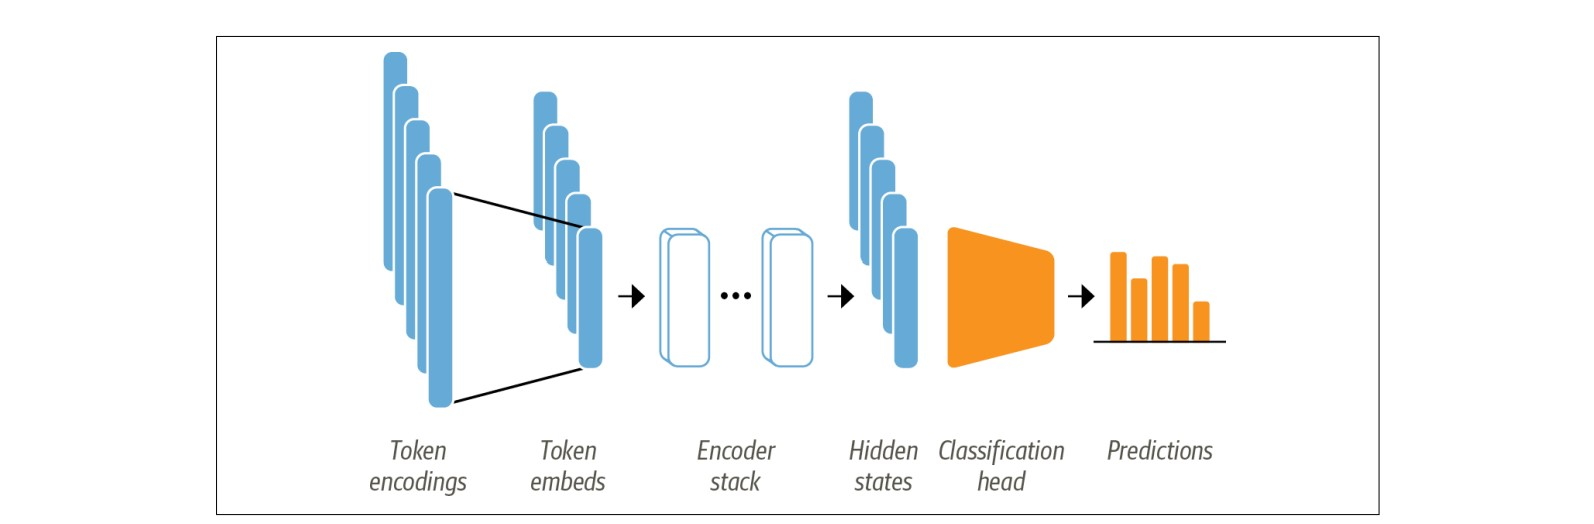

## Coding

In [ ]:
! pip install -U transformers
! pip install -U accelerate
! pip install -U datasets
! pip install -U bertviz
! pip install -U umap-learn
! pip install seaborn --upgrade

! pip install -U openpyxl

# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━

In [ ]:
import pandas as pd

df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")

In [ ]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [ ]:
df.shape

df['label'].value_counts()

,count
label,
0,10361
1,7920


## Dataset Analysis

In [ ]:
import matplotlib.pyplot as plt

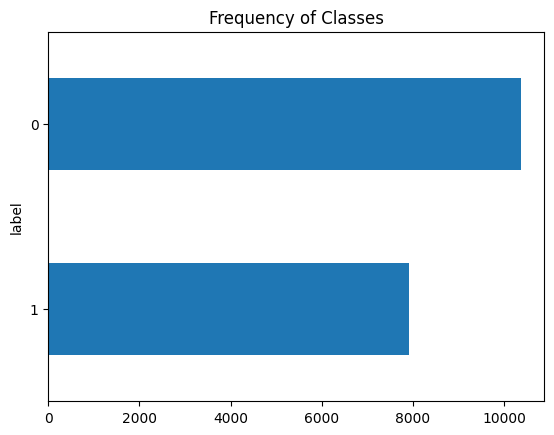

In [ ]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

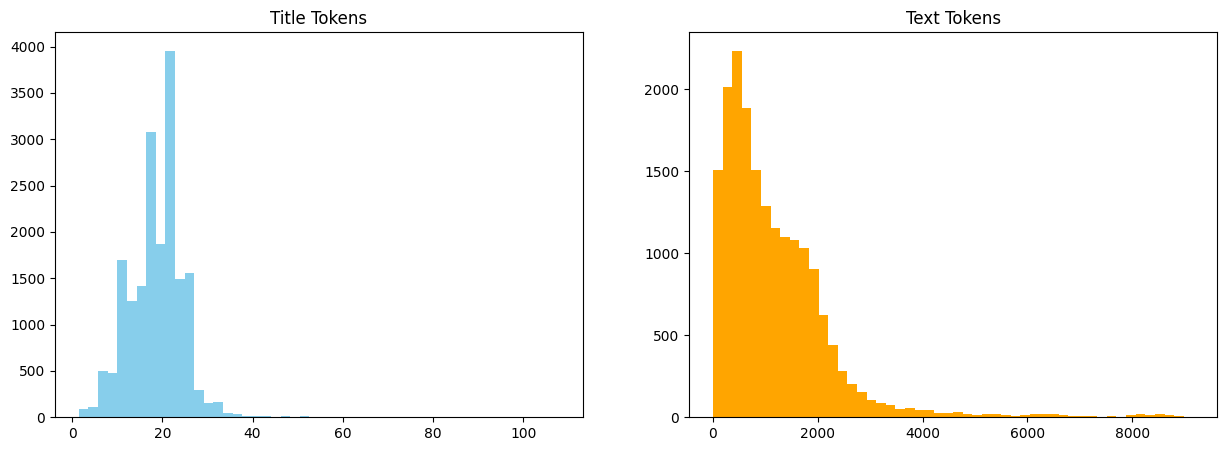

In [ ]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

## Data Loader and Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape



((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## Data Tokenization

In [ ]:
from transformers import AutoTokenizer

text = "Machine learning is awesome!! Thanks KGP Talkie."

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=1000

In [ ]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2009, 1521, 1055, 2006, 999, 2090, 4241, 3334, 2618, 1998, 2637, 102], [101, 5192, 2231, 1999, 2148, 4420, 102, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}


In [ ]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## Model Building

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)




model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.45.2",
  "vocab_size": 30522
}

## Model Fine-Tuning

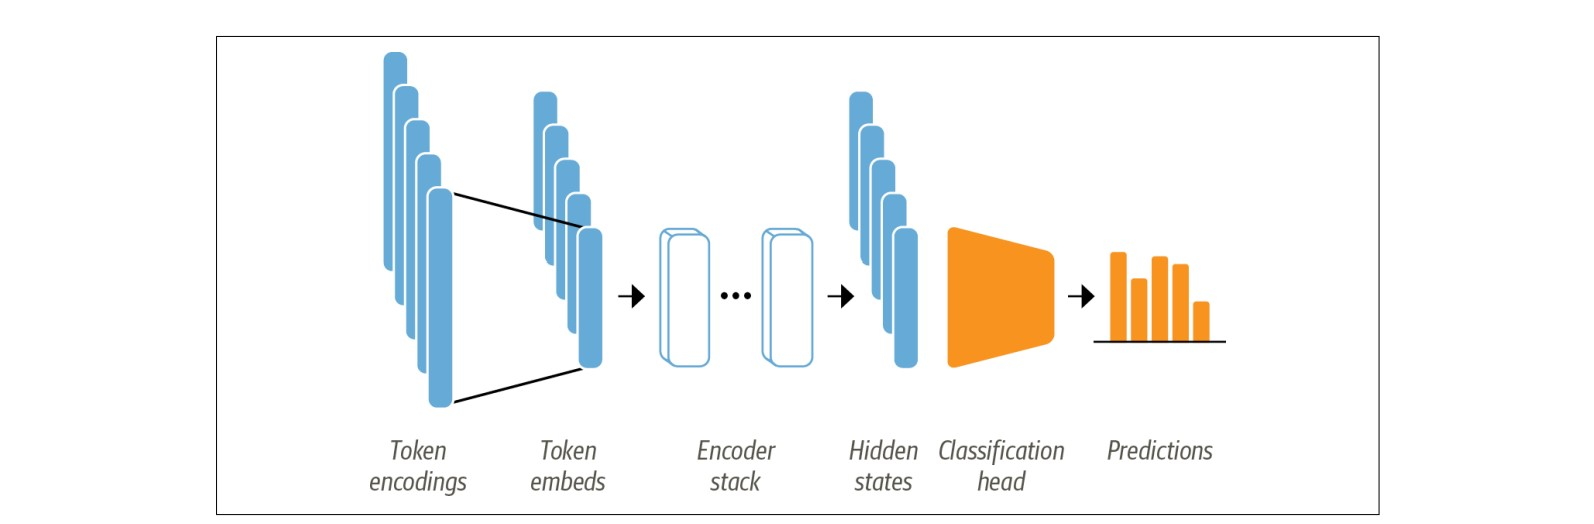

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

#### Evaluator

https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [ ]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00


In [ ]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch'
)



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.244000
1000,0.168300
1500,0.141800
2000,0.086900
2500,0.065800
3000,0.070200
3500,0.044700
4000,0.018400
4500,0.023300


TrainOutput(global_step=4800, training_loss=0.091773109237353, metrics={'train_runtime': 504.0196, 'train_samples_per_second': 76.164, 'train_steps_per_second': 9.523, 'total_flos': 953467218676224.0, 'train_loss': 0.091773109237353, 'epoch': 3.0})

## Model Evaluation

In [ ]:
preds_output = trainer.predict(encoded_dataset['test'])


In [ ]:
preds_output.metrics

{'test_loss': 0.2093961387872696,
 'test_accuracy': 0.9619803063457331,
 'test_runtime': 9.3012,
 'test_samples_per_second': 393.066,
 'test_steps_per_second': 49.133}

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.97      0.97      0.97      2072
        Fake       0.96      0.96      0.96      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## Benchmarking

In [ ]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics


import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  bert-base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.256900
1000,0.188600
1500,0.158000
2000,0.110800
2500,0.079500
3000,0.093000
3500,0.060700
4000,0.018600
4500,0.027600





Training Model:  distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.256700
1000,0.176000
1500,0.144000
2000,0.085000
2500,0.069100
3000,0.078400
3500,0.048100
4000,0.017500
4500,0.024400





Training Model:  mobilebert


pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,52904.852000
1000,0.323300
1500,0.179000
2000,0.132200
2500,0.208500
3000,0.116000
3500,0.073100
4000,0.034300
4500,0.040300





Training Model:  tinybert


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.311500
1000,0.207700
1500,0.187400
2000,0.142300
2500,0.134500


Step,Training Loss
500,0.311500
1000,0.207700
1500,0.187400
2000,0.142300
2500,0.134500
3000,0.126600
3500,0.105500
4000,0.086900
4500,0.067500


In [36]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.22553348541259766,
   'test_accuracy': 0.9597921225382933,
   'test_f1': 0.9598024293659356,
   'test_runtime': 17.1332,
   'test_samples_per_second': 213.387,
   'test_steps_per_second': 26.673},
  'time taken': 1075.1587710380554},
 'distilbert': {'distilbert': {'test_loss': 0.19683590531349182,
   'test_accuracy': 0.962527352297593,
   'test_f1': 0.9625315044749988,
   'test_runtime': 9.2513,
   'test_samples_per_second': 395.188,
   'test_steps_per_second': 49.398},
  'time taken': 485.3168852329254},
 'mobilebert': {'mobilebert': {'test_loss': 0.2458803951740265,
   'test_accuracy': 0.9573304157549234,
   'test_f1': 0.9573398112418193,
   'test_runtime': 18.4852,
   'test_samples_per_second': 197.78,
   'test_steps_per_second': 24.722},
  'time taken': 897.1830017566681},
 'tinybert': {'tinybert': {'test_loss': 0.23211368918418884,
   'test_accuracy': 0.9545951859956237,
   'test_f1': 0.9544680607772558,
   'test_runtime': 2.9825,
   'te

# Model Load and Save

In [37]:
trainer.save_model("fake_news")

In [38]:
from transformers import pipeline

classifier = pipeline('text-classification', model= 'fake_news')


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [39]:
classifier("some text data")

[{'label': 'Fake', 'score': 0.9998059868812561}]